In [78]:
# tools for handling files
import sys
import os
# pandas/numpy for handling data
import pandas as pd
import numpy as np
# seaborn/matplotlib for graphing
import matplotlib.pyplot as plt
import seaborn as sns
# statistics
from statistics import mean 
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats

# for reading individual telomere length data from files
from ast import literal_eval
# for grabbing individual cells
import more_itertools
# my module containing functions for handling/visualizing/analyzing telomere length/chr rearrangement data
import telomere_methods_rad_patient as trp

# machine learning 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, auc, accuracy_score, r2_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from bayes_opt import BayesianOptimization
import xgboost
import shap
import imgkit

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# incase reloading modules is required
import importlib
%load_ext autoreload
%autoreload 

# setting darkgrid style for seaborn figures
# sns.set(font='helvetica')
sns.set_style(style="darkgrid",rc= {'patch.edgecolor': 'black'})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Machine Learning (ML) - predicting mean telomere length post-therapy (4 C) using pre-therapy individual telos

## Loading/merging data for ML

In [2]:
exploded_telos_all_patients_df = pd.read_csv('../data/compiled patient data csv files/exploded_telos_all_patients_df.csv')
all_patients_df = pd.read_csv('../data/compiled patient data csv files/all_patients_df.csv')

In [3]:
# cleaning & combing data; retaining features of interest
telo_data = trp.combine_data(exploded_telos=exploded_telos_all_patients_df, all_patients_df=all_patients_df)
print(telo_data.shape)
telo_data.head()

(128800, 4)


,patient id,timepoint,individual telomeres,4 C telo means
0,1,1 non irrad,70.743017,99.346299
1,1,2 irrad @ 4 Gy,91.860335,99.346299
2,1,1 non irrad,91.860335,99.346299
3,1,2 irrad @ 4 Gy,119.311656,99.346299
4,1,1 non irrad,59.128492,99.346299


## Train/test split 

In [4]:
telo_test = telo_data.copy()
train_set, test_set = train_test_split(telo_test, test_size=0.2, shuffle=True, stratify=telo_test[['patient id', 'timepoint']])

## Initializing cleaning/model pipelines

In [5]:
clean_process_pipe = Pipeline([('features', trp.make_features(make_log_target=False)), 
                               ('dummies', trp.make_dummies(drop_first=True)),
                               ('cleaner', trp.clean_data(drop_patient_id=True))
                              ])

In [6]:
model = XGBRegressor(n_estimators=200, max_depth=7, learning_rate=0.2,
                     objective ='reg:squarederror', random_state=1)

xgb_pipe = Pipeline([('XGB', model)
                    ])

full_pipe = Pipeline([('clean_process', clean_process_pipe),
                      ('model', model)
                     ])

## Cleaning data with pipeline

In [7]:
train_clean = train_set.copy()
test_clean = test_set.copy()

train_clean = clean_process_pipe.fit_transform(train_clean)
test_clean = clean_process_pipe.fit_transform(test_clean)

## Random GridSearch for pipeline/model params

In [121]:
# #XGBoost params for random grid search
# param_grid = {'XGB__max_depth': [3, 7, 9],
#               'XGB__learning_rate': [0.05, 0.1]}

# X_train = train_clean[['individual telomeres', 'timepoint_1']].copy()
# y_train = train_clean['4 C telo means'].copy()

# folds = KFold(5, shuffle=True, random_state=0)
# df_results, best_estimator = trp.grid_search(X_train, y_train, xgb_pipe, param_grid, 
#                                           scoring='neg_mean_absolute_error', cv=folds, n_iter=2)
# print(best_estimator)

## Bayesian Optimization

In [122]:
# target = '4 C telo means'
# features = [col for col in train_clean if col != target and col != 'patient id']

# X_train = train_clean[features].copy()
# y_train = train_clean[target].copy()

In [123]:
# pbounds = {
#     'learning_rate': (0.1, 0.2),
#     'n_estimators': (100, 200),
#     'max_depth': (3, 30),
#     'subsample': (.80, 1.0),  
#     'colsample': (1.0, 1.0),  # Change for datasets with lots of features
#     'gamma': (0, 1)}

# def xgboost_hyper_param(learning_rate, n_estimators, max_depth,
#                         subsample, colsample, gamma):
 
#     max_depth = int(max_depth)
#     n_estimators = int(n_estimators)
 
#     clf = XGBRegressor(max_depth=max_depth,
#                        learning_rate=learning_rate,
#                        n_estimators=n_estimators,
#                        gamma=gamma, objective='reg:squarederror')
    
#     return np.mean(cross_val_score(clf, X_train, y_train, cv=5, scoring='neg_mean_absolute_error'))
 
# optimizer = BayesianOptimization(
#     f=xgboost_hyper_param,
#     pbounds=pbounds,
#     random_state=1,)

# optimizer.maximize(init_points=10, n_iter=5)

In [124]:
# bayesian optimized model
# bo_model = XGBRegressor(n_estimators=260, max_depth=17, learning_rate=0.25,
#                        objective ='reg:squarederror', random_state=0, subsample=.9,
#                        gamma=1.7)

## Visualizing model objective

In [ ]:
train_viz = train_set.copy()
train_viz.sort_values(by=['patient id'], axis=0, ascending=True, inplace=True)
trp.plot_individ_telos_ML_objective(df=train_viz, target='4 C telo means')

## Cross validation; MAE & R2 score 

In [65]:
# predicting mean telo telo post-therapy (4 C) using individual telos
fit_xgb_model, telo_row = trp.cv_score_fit_mae_test(train_set=train_clean, test_set=test_clean,
                                                    model=model, cv=5)

MAE per CV fold: 
[3.27683484 3.19793861 3.27503828 3.21618978 3.36331028] 

MEAN of MAE all folds: 3.265862357896529
STD of MAE all folds: 0.05793391522441506

MAE of predict_y_test & y_test: 3.1218286703421994
R2 between predict_y_test & y_test: 0.8904561995059634


In [66]:
# evaluating model based on N samples in training data
model_df = []

for n in [100, 500, 1000, 2000, 4000, 8000, 16000, 32000, 64000, 103040]:
    fit_xgb_model, telo_row = trp.cv_score_fit_mae_test(train_set=train_clean.sample(n), test_set=test_clean,
                                                        model=model, cv=5, verbose=False)
    telo_row[0].append(n)
    model_df += (telo_row)

In [67]:
model_metrics_n_train = pd.DataFrame(model_df, 
                                     columns=['Model', 'Features', 'Target', 'Average MAE of CV folds', 
                                              'Std dev of MAE of CV folds', 'MAE predicted vs. test values', 
                                              'R2 predicted vs. test values', 'N samples training data'])
display(model_metrics_n_train)
path=f'../graphs/paper figures/supp figs/ML model metrics target_4C mean telos | per N training samples 100 to 100000.png'
trp.df_to_png(df=model_metrics_n_train, path=path)

,Model,Features,Target,Average MAE of CV folds,Std dev of MAE of CV folds,MAE predicted vs. test values,R2 predicted vs. test values,N samples training data
0,XGBoost,"[individual telomeres, timepoint_2 irrad @ 4 Gy]",4 C telo means,11.9542,1.4232,12.5126,-0.6014,100
1,XGBoost,"[individual telomeres, timepoint_2 irrad @ 4 Gy]",4 C telo means,10.3139,0.5432,9.8092,-0.1183,500
2,XGBoost,"[individual telomeres, timepoint_2 irrad @ 4 Gy]",4 C telo means,8.3336,0.2890,7.9362,0.2027,1000
3,XGBoost,"[individual telomeres, timepoint_2 irrad @ 4 Gy]",4 C telo means,6.7396,0.2776,6.2869,0.4774,2000
4,XGBoost,"[individual telomeres, timepoint_2 irrad @ 4 Gy]",4 C telo means,5.2961,0.3084,4.4563,0.7492,4000
5,XGBoost,"[individual telomeres, timepoint_2 irrad @ 4 Gy]",4 C telo means,4.1267,0.0897,4.0339,0.7956,8000
6,XGBoost,"[individual telomeres, timepoint_2 irrad @ 4 Gy]",4 C telo means,3.6029,0.0334,3.4566,0.8581,16000
7,XGBoost,"[individual telomeres, timepoint_2 irrad @ 4 Gy]",4 C telo means,3.3478,0.0524,3.3249,0.8754,32000
8,XGBoost,"[individual telomeres, timepoint_2 irrad @ 4 Gy]",4 C telo means,3.3392,0.0652,3.2296,0.8803,64000
9,XGBoost,"[individual telomeres, timepoint_2 irrad @ 4 Gy]",4 C telo means,3.2596,0.0509,3.1218,0.8905,103040


Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


## Checking predicted values on per patient basis

In [10]:
full_df = trp.fit_model_return_df_predictions(test_set=test_set, fit_model=fit_xgb_model)

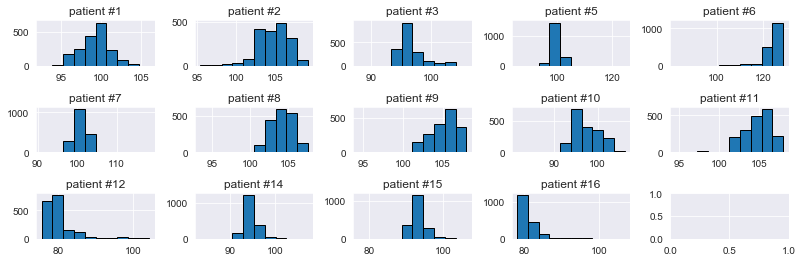

In [11]:
patient_IDs = list(full_df.sort_values(by=['patient id'], ascending=True)['patient id'].unique())

fig, ax = plt.subplots(3, 5, figsize=(11.25,3.75))
axes = ax.ravel()

for axe, patient_ID in zip(axes, patient_IDs):
    df = full_df[full_df['patient id'] == patient_ID].copy()
    df['predictions'].hist(ax=axe)
    axe.set_title(f'patient #{patient_ID}', fontsize=12)
plt.tight_layout()

In [34]:
y_predict_list, y_true_list = trp.predict_target_4C_compare_actual(telo_data=telo_test, test_set=test_set, 
                                                                   model=fit_xgb_model, target='4 C telo means',
                                                                   clean_process_pipe=clean_process_pipe, verbose=False)

MAE predicted vs. actual 4 C telo means: 2.9135967557832836
R2 predicted vs. actual 4 C telo means: 0.9318641595580759


In [64]:
plt.figure(figsize=(6,6))
ax = sns.regplot(x=y_true_list, y=y_predict_list, scatter_kws={'s':200, 'edgecolor':'k'}, )
ax.set_xlabel('Actual mean telomere length post-therapy', fontsize=14)
ax.set_ylabel('Predicted mean telomere length post-therapy', fontsize=14)
ax.tick_params(labelsize=14)
# ax.set_title('Fig. 1', fontsize=22, weight='bold')
plt.savefig(f'../graphs/paper figures/main figs/ML model actual 4 C mean telos vs predicted.png', 
            dpi=400, bbox_inches = "tight")

NameError: name 'y_true_list' is not defined

<Figure size 432x432 with 0 Axes>

## Dataframe for model metrics

In [129]:
stats_df = trp.make_stats_df(stats_list=telo_row)
stats_df

,Model,Features,Target,Average MAE of CV folds,Std dev of MAE of CV folds,MAE predicted vs. test values,R2 predicted vs. test values
0,XGBoost,"[individual telomeres, timepoint_2 irrad @ 4 Gy]",4 C telo means,3.1847,0.0244,3.1211,0.8872


In [130]:
path=f'../graphs/paper figures/supp figs/ML model metrics target_4C mean telos | features_individ telos.png'
trp.df_to_png(df=stats_df, path=path)

Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


## Trialing model interpretability functions

In [76]:
shap.initjs()

X = test_clean.drop('4 C telo means', axis=1).sample(5000, random_state=2)

# explain the model's predictions using SHAP
explainer = shap.TreeExplainer(fit_xgb_model)
shap_values = explainer.shap_values(X)

# change to jupyter theme light mode for viz
shap.force_plot(explainer.expected_value, shap_values, X)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
shap.force_plot is slow for many thousands of rows, try subsampling your data.


## Testing if linear regression can predict 4C mean telos using individual telos

In [ ]:
lr_model = LinearRegression(normalize=True)
lr_pipe = Pipeline([('lr_model', lr_model)
                   ])

In [ ]:
# predicting mean telo telo post-therapy (4 C) using individual telos
fit_lr_model, row = trp.cv_score_fit_mae_test(train_set=train_clean, test_set=test_clean,
                                              model=lr_model, cv=5)

In [ ]:
lr_y_predict_list, y_true_list = trp.predict_target_4C_compare_actual(telo_data=telo_test, test_set=test_set, 
                                     model=fit_lr_model, target='4 C telo means',
                                     clean_process_pipe=clean_process_pipe, verbose=False)

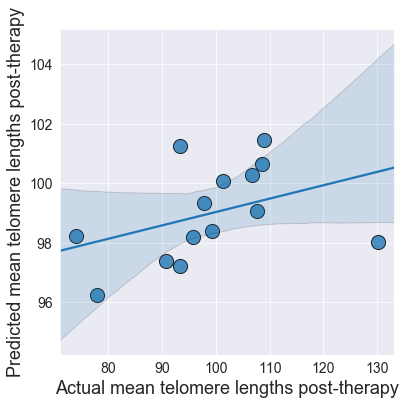

In [26]:
plt.figure(figsize=(6,6))
ax = sns.regplot(x=y_true_list, y=lr_y_predict_list, scatter_kws={'s':200, 'edgecolor':'k'},)
ax.set_xlabel('Actual mean telomere lengths post-therapy', fontsize=18)
ax.set_ylabel('Predicted mean telomere lengths post-therapy', fontsize=18)
ax.tick_params(labelsize=14)

# Machine Learning - exploring predictions of #s of short telomeres post-therapy

## Loading/merging data for ML

In [37]:
exploded_telos_all_patients_df = pd.read_csv('../data/compiled patient data csv files/exploded_telos_all_patients_df.csv')
all_patients_df = pd.read_csv('../data/compiled patient data csv files/all_patients_df.csv')

In [38]:
# cleaning & combing data; retaining features of interest
quartile_telo_data = trp.combine_data(exploded_telos=exploded_telos_all_patients_df, 
                                      all_patients_df=all_patients_df,
                                      prediction_objective='4 C # short telos from individual telos')
quartile_telo_data.head()

,patient id,timepoint,individual telomeres,4 C # short telos
0,1,1 non irrad,70.743017,372
1,1,2 irrad @ 4 Gy,91.860335,372
2,1,1 non irrad,91.860335,372
3,1,2 irrad @ 4 Gy,119.311656,372
4,1,1 non irrad,59.128492,372


## Train/test split 

In [54]:
quartile_telo_test = quartile_telo_data.copy()

y = quartile_telo_test[['4 C # short telos']]
X = quartile_telo_test.drop(['4 C # short telos'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)

q_train_set = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
q_test_set = pd.concat([X_test, y_test], axis=1).reset_index(drop=True)

## Initializing cleaning/model pipelines

In [55]:
q_clean_process_pipe = Pipeline([('features', trp.make_features(make_log_target=False)), 
                               ('dummies', trp.make_dummies(drop_first=True)),
                               ('cleaner', trp.clean_data(drop_patient_id=True))
                              ])

In [56]:
# initialize XGBoost model & pipeline for hyperparams gridsearch
q_model = XGBRegressor(n_estimators=200, max_depth=6, learning_rate=0.2,
                       objective='reg:squarederror', random_state=0, gamma=3)

q_xgb_pipe = Pipeline([('XGB', model)
                      ])

q_full_pipe = Pipeline([('clean_process', q_clean_process_pipe),
                        ('model', q_model)
                       ])

## Cleaning/modeling data with pipeline

In [42]:
q_train_clean = q_train_set.copy()
q_test_clean = q_test_set.copy()

q_train_clean = q_clean_process_pipe.fit_transform(q_train_clean)
q_test_clean = q_clean_process_pipe.fit_transform(q_test_clean)

## Visualizing model objective

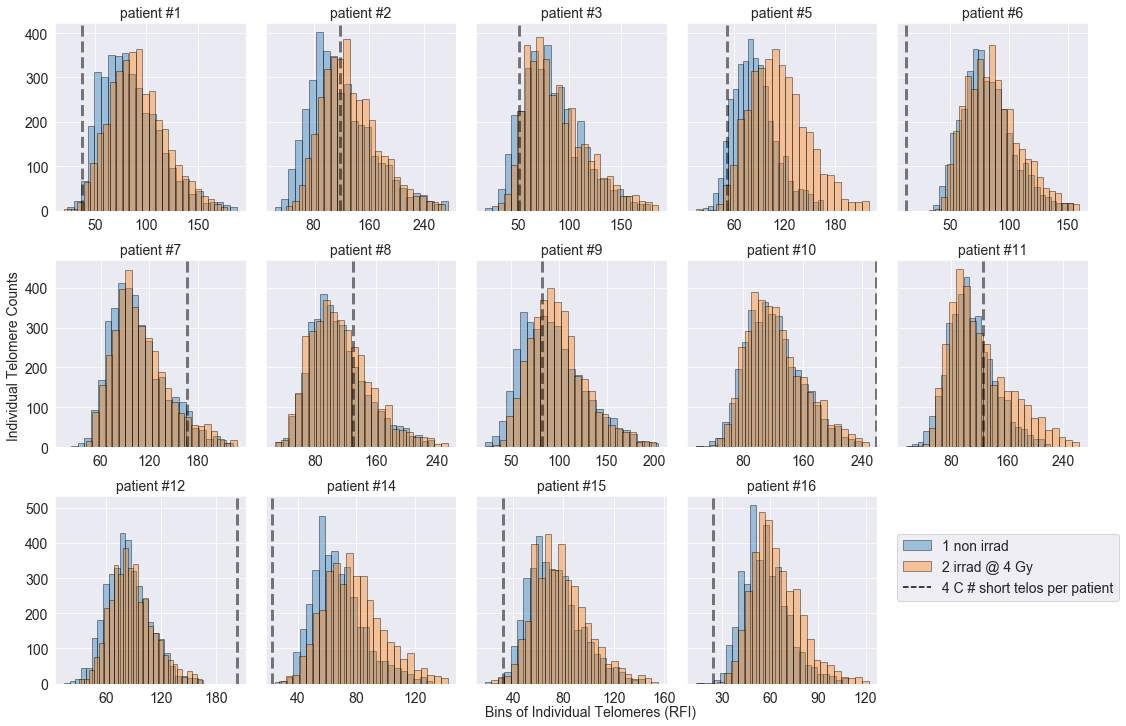

In [29]:
q_train_set.sort_values(by='patient id', ascending=True, inplace=True)
q_train_set.reset_index(drop=True, inplace=True)
temp = q_train_set.copy()
temp['4 C # short telos'] = temp['4 C # short telos'] / 10

trp.plot_individ_telos_ML_objective(df=temp, target='4 C # short telos')

## Cross validation; MAE & R2 score when predicting # of short telomeres post-therapy (4 C)

In [69]:
# evaluating model based on N samples in training data
model_df = []

for n in [100, 500, 1000, 2000, 4000, 8000, 16000, 32000, 64000, 103040]:
    q_fit_xgb_model, short_telos_row = trp.cv_score_fit_mae_test(train_set=q_train_clean.sample(n), 
                                                                 test_set=q_test_clean, model=q_model, 
                                                                 cv=5, target='4 C # short telos',
                                                                 verbose=False)
    short_telos_row[0].append(n)
    model_df += (short_telos_row)

In [70]:
q_model_metrics_n_train = pd.DataFrame(model_df, 
                                     columns=['Model', 'Features', 'Target', 'Average MAE of CV folds', 
                                              'Std dev of MAE of CV folds', 'MAE predicted vs. test values', 
                                              'R2 predicted vs. test values', 'N samples training data'])
display(q_model_metrics_n_train)
path=f'../graphs/paper figures/supp figs/ML model metrics target_4C number short telos | per N training samples 100 to 100000.png'
trp.df_to_png(df=q_model_metrics_n_train, path=path)

,Model,Features,Target,Average MAE of CV folds,Std dev of MAE of CV folds,MAE predicted vs. test values,R2 predicted vs. test values,N samples training data
0,XGBoost,"[individual telomeres, timepoint_2 irrad @ 4 Gy]",4 C # short telos,601.7914,55.1738,652.7456,-0.4375,100
1,XGBoost,"[individual telomeres, timepoint_2 irrad @ 4 Gy]",4 C # short telos,580.2456,54.0877,527.5787,-0.0447,500
2,XGBoost,"[individual telomeres, timepoint_2 irrad @ 4 Gy]",4 C # short telos,429.8518,43.6952,424.2776,0.2573,1000
3,XGBoost,"[individual telomeres, timepoint_2 irrad @ 4 Gy]",4 C # short telos,353.7109,13.8230,352.1672,0.4743,2000
4,XGBoost,"[individual telomeres, timepoint_2 irrad @ 4 Gy]",4 C # short telos,306.1732,10.8307,293.3357,0.6524,4000
5,XGBoost,"[individual telomeres, timepoint_2 irrad @ 4 Gy]",4 C # short telos,263.5980,3.6435,260.7129,0.7403,8000
6,XGBoost,"[individual telomeres, timepoint_2 irrad @ 4 Gy]",4 C # short telos,254.6321,6.1479,252.4540,0.7760,16000
7,XGBoost,"[individual telomeres, timepoint_2 irrad @ 4 Gy]",4 C # short telos,242.6359,4.6286,240.4630,0.8024,32000
8,XGBoost,"[individual telomeres, timepoint_2 irrad @ 4 Gy]",4 C # short telos,235.3119,1.7607,234.5637,0.8113,64000
9,XGBoost,"[individual telomeres, timepoint_2 irrad @ 4 Gy]",4 C # short telos,234.2835,4.6707,228.8167,0.8206,103040


Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


In [59]:
q_y_xgb_predict, q_y_true = trp.predict_target_4C_compare_actual(telo_data=quartile_telo_data, test_set=q_test_set, 
                                                                 model=q_fit_xgb_model, target='4 C # short telos',
                                                                 clean_process_pipe=q_clean_process_pipe, verbose=False)

MAE predicted vs. actual 4 C # short telos: 204.37520490373885
R2 predicted vs. actual 4 C # short telos: 0.8806536788219753


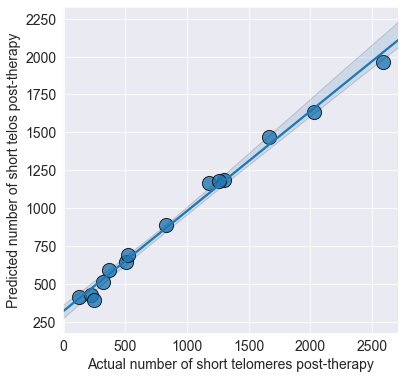

In [63]:
plt.figure(figsize=(6,6))
ax = sns.regplot(x=q_y_true, y=q_y_xgb_predict, scatter_kws={'s':200, 'edgecolor':'k'}, )
ax.set_xlabel('Actual number of short telomeres post-therapy', fontsize=14)
ax.set_ylabel('Predicted number of short telos post-therapy', fontsize=14)
ax.tick_params(labelsize=14)
# ax.set_title('Fig. 2', weight='bold', fontsize=20)
plt.savefig(f'../graphs/paper figures/main figs/ML model actual 4 C # short telomeres vs predicted.png', 
            dpi=400, bbox_inches = "tight")

## Dataframe for model metrics

In [61]:
telos_short_telos_rows = telo_row + short_telos_row
stats_df = trp.make_stats_df(stats_list=telos_short_telos_rows)
stats_df

NameError: name 'telo_row' is not defined

In [62]:
path=f'../graphs/paper figures/supp figs/ML models predicting #1 4 C telo means and #2 # short telos.png'
trp.df_to_png(df=stats_df, path=path)

NameError: name 'stats_df' is not defined

# Machine Learning - exploring predictions of chromosome rearrangements

## Loading data & general cleaning

In [56]:
all_chr_aberr_df = pd.read_csv('../data/compiled patient data csv files/all_chr_aberr_df.csv')

general_cleaner = Pipeline([('cleaner', trp.general_chr_aberr_cleaner())])
cleaned_chr_df = general_cleaner.fit_transform(all_chr_aberr_df)

## Train/test split 

In [57]:
chr_train, chr_test = train_test_split(cleaned_chr_df, test_size=0.2, shuffle=True, 
                                       stratify=cleaned_chr_df[['patient id', 'timepoint']])

In [58]:
chr_train = chr_train.copy()
for col in chr_train.columns:
    if col != 'patient id' and col != 'timepoint':
        chr_train[col] = chr_train[col] + 1
#         chr_train[col] = np.log10(chr_train[col])
        
chr_test = chr_test.copy()
for col in chr_test.columns:
    if col != 'patient id' and col != 'timepoint':
        chr_test[col] = chr_test[col] + 1
#         chr_test[col] = np.log10(chr_test[col])

In [59]:
chr_train.head()

,patient id,timepoint,# inversions,# terminal inversions,# sister chromatid exchanges,# dicentrics,excess chr fragments,# sat associations,# terminal SCEs,# translocations
1163,15,4 C,1,2,1,1,1,1,1,2
1015,14,1 non irrad,1,2,2,1,1,1,1,1
834,11,1 non irrad,1,1,2,1,1,1,2,1
996,14,1 non irrad,1,1,1,1,1,2,3,1
662,9,2 irrad @ 4 Gy,1,1,1,3,2,1,2,1


## Initializing cleaning/model pipelines

In [60]:
features = ['# inversions']
target = '# inversions'

make_new_features_target = Pipeline([('make features', trp.make_chr_features(combine_inversions=False, 
                                                                             bool_features=False,
                                                                             features=features)),
                                     ('make target merge', trp.make_target_merge(target=target, features=features))])

In [61]:
# initialize XGBoost model & pipeline for hyperparams gridsearch
chr_model = XGBRegressor(n_estimators=200, max_depth=15, learning_rate=0.1,
                         objective='reg:squarederror',
                         random_state=0,
                        )

chr_xgb_pipe = Pipeline([('XGB', chr_model)
                        ])

chr_full_pipe = Pipeline([('make ftr target', make_new_features_target),
                          ('model', chr_model)
                         ])

## Cleaning/modeling data with pipeline

In [62]:
cleaned_chr_train = chr_train.copy()
cleaned_chr_test = chr_test.copy()

cleaned_chr_train = make_new_features_target.fit_transform(cleaned_chr_train)
cleaned_chr_test = make_new_features_target.fit_transform(cleaned_chr_test)

In [63]:
cleaned_chr_test.head()

,patient id,# inversions,4 C # inversions,timepoint_2 irrad @ 4 Gy
1,10,2,1.5,1
2,10,1,1.5,0
3,10,1,1.5,0
4,10,1,1.5,0
5,10,1,1.5,0


## Cross validation; MAE & R2 score when predicting # of chr aberrations post-therapy (4 C)

In [64]:
bo_model = XGBRegressor(n_estimators=300, 
                        max_depth=10, 
                        learning_rate=0.2,
                        objective='reg:squarederror',
#                         colsample=.8897,
#                         gamma=3.185,
                        random_state=0,
                        )

In [65]:
# score model by cross validation, 5 folds, on X/y_train data 
# fit model on train data; w/ model, predict y_test from X_test; score model by MAE/R2 - return model
chr_fit_xgb_model, row = trp.cv_score_fit_mae_test(train_set=cleaned_chr_train, test_set=cleaned_chr_test,
                                              model=chr_model, cv=5, target='4 C # inversions')

MAE per CV fold: 
[0.07646633 0.05364477 0.08961146 0.07383656 0.17262226] 

MEAN of MAE all folds: 0.09323627658327004
STD of MAE all folds: 0.0413287811261603

MAE of predict_y_test & y_test: 0.2815044806117103
R2 between predict_y_test & y_test: -0.031219299385835564


In [40]:
chr_y_predict, y_true, = trp.chr_aberr_predict_target_4C_compare_actual(cleaned_unsplit_chr_data=cleaned_chr_df, 
                                                                        cleaned_test_set=cleaned_chr_test, 
                                                                        model=chr_fit_xgb_model, target='4 C # inversions',
                                                                        clean_process_pipe=make_new_features_target, verbose=False)

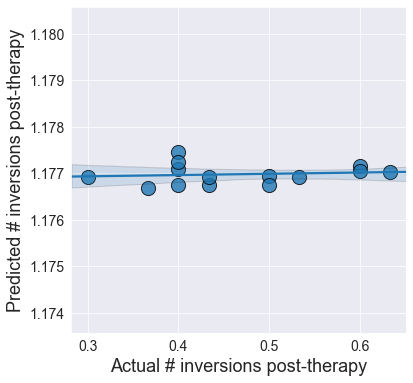

In [41]:
plt.figure(figsize=(6,6))
ax = sns.regplot(x=y_true, y=chr_y_predict, scatter_kws={'s':200, 'edgecolor':'k'}, )
ax.set_xlabel('Actual # inversions post-therapy', fontsize=18)
ax.set_ylabel('Predicted # inversions post-therapy', fontsize=18)
ax.tick_params(labelsize=14)
# ax.set_title('Fig. 2', weight='bold', fontsize=20)

## Looping through all chr aberration types for XGBoost model fitting, creating dict for graphing & list for displaying model metrics

In [3]:
features_list = [['# inversions'], ['# terminal inversions'], ['# translocations'], ['# dicentrics'],
                 ['# inversions', '# terminal inversions', '# translocations', '# dicentrics']]

           
target1_list = ['# inversions', '# terminal inversions', '# translocations', '# dicentrics',
                'aberration index']

target2_list = ['4 C # inversions', '4 C # terminal inversions', '4 C # translocations', '4 C # dicentrics',
                '4 C aberration index']

stats_list = []
stats_list, graphing_dict = trp.script_load_clean_data_ml_pipeline_loop_aberrations(features_list=features_list,
                                                                                    target1_list=target1_list,
                                                                                    target2_list=target2_list,
                                                                                    stats_list=stats_list,
                                                                                    verbose=False)

## Displaying model metrics in dataframe & graphing performance

In [5]:
graphing_df = trp.make_graphing_df(graphing_dict=graphing_dict)
stats_df = trp.make_stats_df(stats_list=stats_list)
display(stats_df)
path=f'../graphs/paper figures/supp figs/ML models predicting chr aberration types.png'
trp.df_to_png(df=stats_df, path=path)

,Model,Features,Target,Average MAE of CV folds,Std dev of MAE of CV folds,MAE predicted vs. test values,R2 predicted vs. test values
0,XGBoost,"[# inversions, timepoint_2 irrad @ 4 Gy]",4 C # inversions,0.1248,0.0142,0.2798,-0.0128
1,XGBoost,"[# terminal inversions, timepoint_2 irrad @ 4 Gy]",4 C # terminal inversions,0.0578,0.0407,0.2025,-0.0010
2,XGBoost,"[# translocations, timepoint_2 irrad @ 4 Gy]",4 C # translocations,0.0509,0.0072,0.1162,-0.0587
3,XGBoost,"[# dicentrics, timepoint_2 irrad @ 4 Gy]",4 C # dicentrics,0.1172,0.0288,0.1847,-0.1421
4,XGBoost,"[# inversions, # terminal inversions, # transl...",4 C aberration index,0.2708,0.0506,0.3886,-0.2307


Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


In [51]:
# saving df of model metrics for all models
all_rows = telo_row + short_telos_row + stats_list
stats_df = trp.make_stats_df(stats_list=all_rows)

path=f'../graphs/paper figures/supp figs/ML models for all telo and chr aberr endpoints.png'
trp.df_to_png(df=stats_df, path=path)

Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


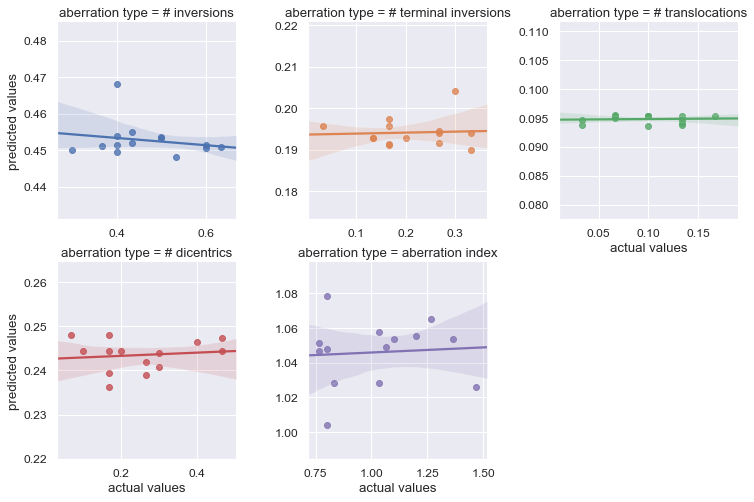

In [52]:
ax = sns.set(font_scale=1.1)
ax = sns.lmplot(x='actual values', y='predicted values', col='aberration type', hue='aberration type', 
           sharex=False, sharey=False, col_wrap=3, data=graphing_df, height=3.5)
plt.tight_layout(pad=.6)

# Clustering telomere data

## Mean telomere length (teloFISH)

In [405]:
all_patients_df = pd.read_csv('../data/compiled patient data csv files/all_patients_df.csv')
means = all_patients_df.drop(['telo data', 'Q1', 'Q2-3', 'Q4'], axis=1)

In [406]:
means.head()

,patient id,timepoint,telo means
0,1,1 non irrad,84.796483
1,1,2 irrad @ 4 Gy,90.975826
2,1,3 B,116.779989
3,1,4 C,99.346299
4,2,1 non irrad,119.773675


In [407]:
pivot = means.pivot_table(index=['patient id'], columns='timepoint', values='telo means').reset_index()
pivot.columns.name = ''

pivot = pivot[pivot['patient id'] != 13].copy()
pivot.set_index(pivot['patient id'], inplace=True)
pivot.drop(['patient id'], axis=1, inplace=True)

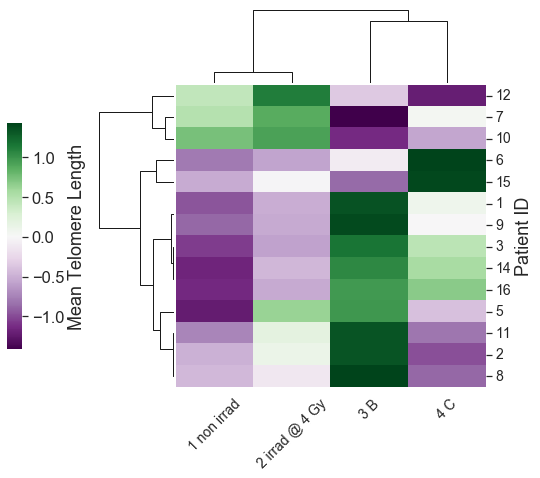

In [408]:
g = sns.clustermap(pivot, method='single', metric='correlation',
                   z_score=0, figsize=(7,7), cmap='PRGn',
#                    standard_scale=0, 
#                    col_cluster=False,
                   cbar_kws={'label':'Mean Telomere Length'},
                  ) 

g.cax.set_position([-0.05, .2, .03, .45])
g.ax_heatmap.set_ylabel('Patient ID')

font_size=14
labels = g.ax_heatmap.yaxis.get_majorticklabels()

plt.setp(g.ax_heatmap.xaxis.get_majorticklabels(), rotation=45, fontsize=font_size)
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), fontsize=font_size)
plt.setp(g.ax_heatmap.yaxis.get_minorticklabels(), fontsize=font_size)
g.ax_heatmap.set_yticklabels(labels, rotation=0, fontsize=font_size, va="center")

for a in g.ax_row_dendrogram.collections:
    a.set_linewidth(1)

for a in g.ax_col_dendrogram.collections:
    a.set_linewidth(1)

plt.savefig('../graphs/paper figures/main figs/CLUSTERING heatmap all patient by mean telomere length means teloFISH.png', 
            dpi=400, bbox_inches = "tight")

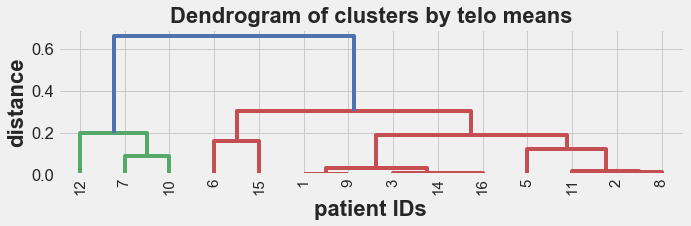

0 Cluster number 2 has 11 elements
1 Cluster number 1 has 3 elements


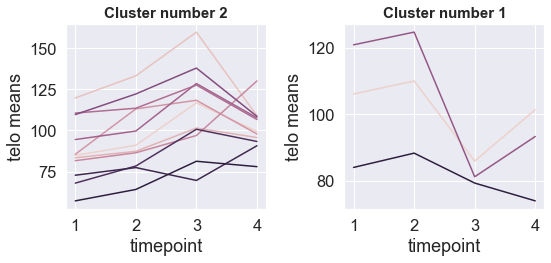

In [374]:
clustered_telos = trp.cluster_data_return_df(means, target='telo means', cut_off_n=2,
                                             metric='correlation', method='single',
                                             x_size=8, y_size=4)

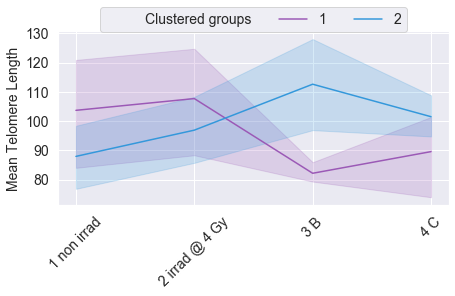

In [426]:
clustered_graphing = clustered_telos.rename({'telo means cluster groups': 'Clustered groups'}, axis=1).copy()

trp.graph_cluster_groups(clustered_graphing, target='telo means', hue='Clustered groups')

telo means CLUSTER 1 | patient IDs: [7, 10, 12]
telo means CLUSTER 2 | patient IDs: [1, 2, 3, 5, 6, 8, 9, 11, 14, 15, 16]


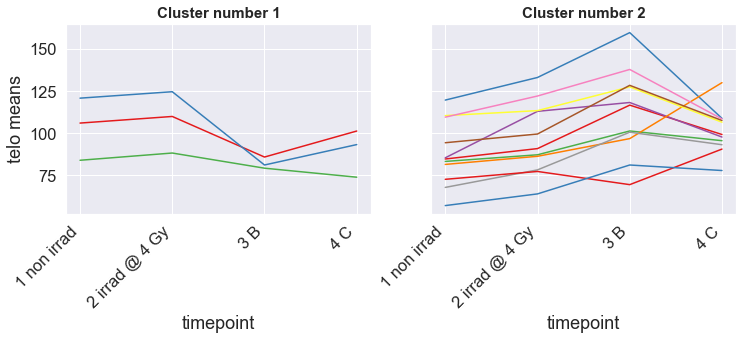

In [25]:
trp.graph_clusters_per_patient(clustered_telos, target='telo means',
                               y_dimen=1, x_dimen=2,
                               fsize=(12,3.5))

## Short telomeres

In [410]:
all_patients_df = pd.read_csv('../data/compiled patient data csv files/all_patients_df.csv')
short_telos = all_patients_df.drop(['telo data', 'Q2-3', 'Q4', 'telo means'], axis=1)
short_telos.rename(columns={'Q1': 'Number of short telomeres'}, inplace=True)

In [411]:
pivot1 = short_telos.pivot_table(index=['patient id'], columns='timepoint', values='Number of short telomeres').reset_index()
pivot1.columns.name = ''

pivot1 = pivot1[pivot1['patient id'] != 13].copy()
pivot1.set_index(pivot1['patient id'], inplace=True)
pivot1.drop(['patient id'], axis=1, inplace=True)

In [412]:
pivot1.head()

,1 non irrad,2 irrad @ 4 Gy,3 B,4 C
patient id,,,,
1,1195.0,724.0,231.0,372.0
2,1166.0,481.0,292.0,1182.0
3,1190.0,1006.0,407.0,503.0
5,1159.0,319.0,234.0,521.0
6,1188.0,929.0,587.0,124.0


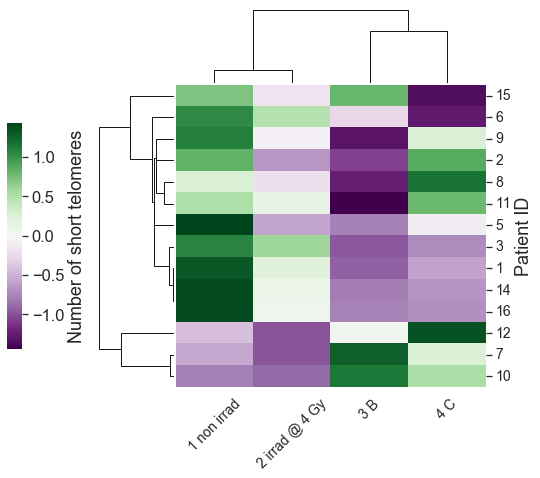

In [413]:
g = sns.clustermap(pivot1, method='single', metric='correlation',
                   z_score=0, figsize=(7,7), cmap='PRGn',
#                    standard_scale=0, 
#                    col_cluster=False,
                   cbar_kws={'label':'Number of short telomeres'},
                  ) 

g.cax.set_position([-0.05, .2, .03, .45])
g.ax_heatmap.set_ylabel('Patient ID')

font_size=14
labels = g.ax_heatmap.yaxis.get_majorticklabels()

plt.setp(g.ax_heatmap.xaxis.get_majorticklabels(), rotation=45, fontsize=font_size)
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), fontsize=font_size)
plt.setp(g.ax_heatmap.yaxis.get_minorticklabels(), fontsize=font_size)
g.ax_heatmap.set_yticklabels(labels, rotation=0, fontsize=font_size, va="center")

for a in g.ax_row_dendrogram.collections:
    a.set_linewidth(1)

for a in g.ax_col_dendrogram.collections:
    a.set_linewidth(1)

plt.savefig('../graphs/paper figures/main figs/CLUSTERING heatmap all patient by short telomeres teloFISH.png', 
            dpi=400, bbox_inches = "tight")

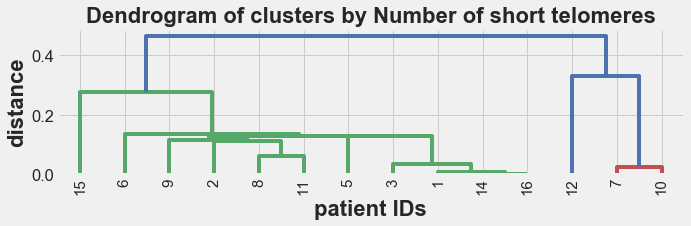

0 Cluster number 1 has 11 elements
1 Cluster number 2 has 3 elements


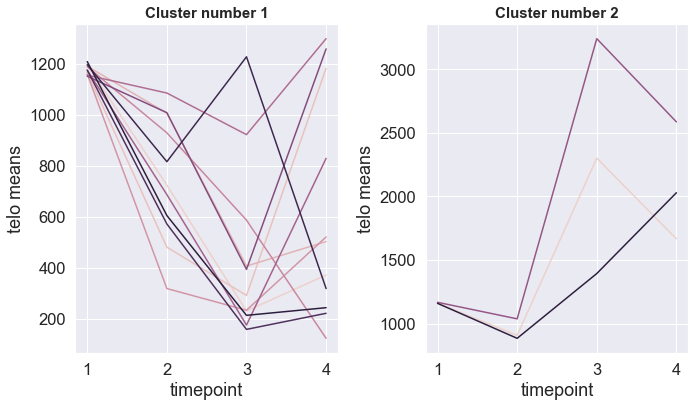

In [414]:
clustered_short_telos = trp.cluster_data_return_df(short_telos, target='Number of short telomeres', cut_off_n=2)

In [420]:
clustered_short_telos['Clustered groups'] = (clustered_short_telos['Number of short telomeres cluster groups']
                                                             .apply(lambda row: trp.swap_short_telos_group_number(row)))

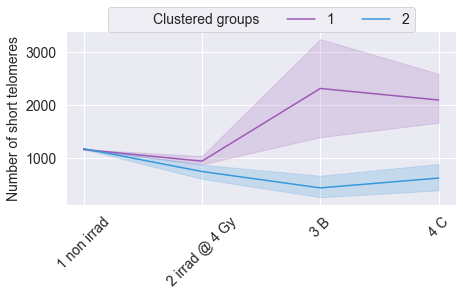

In [423]:
trp.graph_cluster_groups(clustered_short_telos, target='Number of short telomeres', hue='Clustered groups')

# short telomeres CLUSTER 1 | patient IDs: [7, 10, 12]
# short telomeres CLUSTER 2 | patient IDs: [1, 2, 3, 5, 6, 8, 9, 11, 14, 15, 16]


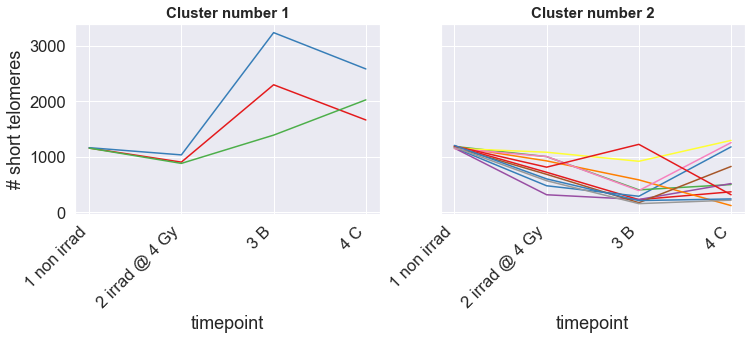

In [31]:
trp.graph_clusters_per_patient(clustered_short_telos, target='# short telomeres',
                               y_dimen=1, x_dimen=2, fsize=(12, 3.5))

Clustering analysis by hierarchical clustering of longitudinal changes in mean telomere length and number of short telomeres in the patients yielded 4 groups in each case, distinguishable by differential responses to radiation therapy. When patients were clustered by mean telomere length or number of short telomeres, the clustered groups differed by only one patient, suggesting strong agreement between mean telomere length and number of short telomeres for data clustering. 

## Combining cluster groups of means + short telos

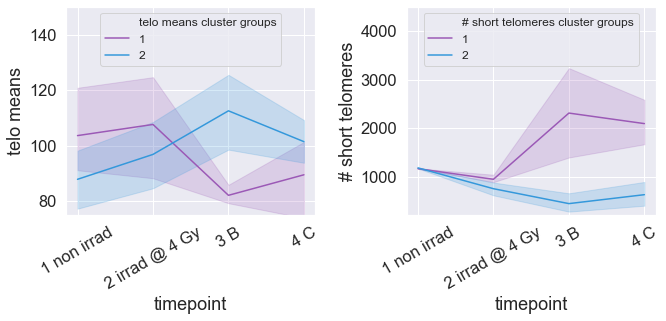

In [33]:
y_list = ['telo means', '# short telomeres']
hue_list = ['telo means cluster groups', '# short telomeres cluster groups']
df_list = [clustered_telos, clustered_short_telos]
ylim_dict = {'telo means': (75, 150),
             '# short telomeres': (200, 4500)}

trp.plot_multiple_types_clusters(y_list=y_list, hue_list=hue_list,
                                 df_list=df_list, ylim_dict=ylim_dict)

## Mean telomere length (qPCR)

In [64]:
all_qPCR_df = pd.read_csv('../qPCR telo data/all_qPCR_df.csv')
means_qPCR = all_qPCR_df.drop(['SEM'], axis=1)
means_qPCR['timepoint'] = means_qPCR['timepoint'].apply(lambda row: trp.encode_timepts(row))
means_qPCR.head()

,patient id,timepoint,telo means qPCR
0,1,1,2.182028
1,1,3,1.964348
2,1,4,1.749799
3,2,1,1.669445
4,2,3,1.780092


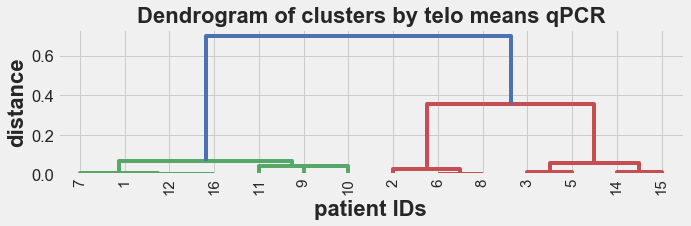

0 Cluster number 1 has 7 elements
1 Cluster number 2 has 7 elements


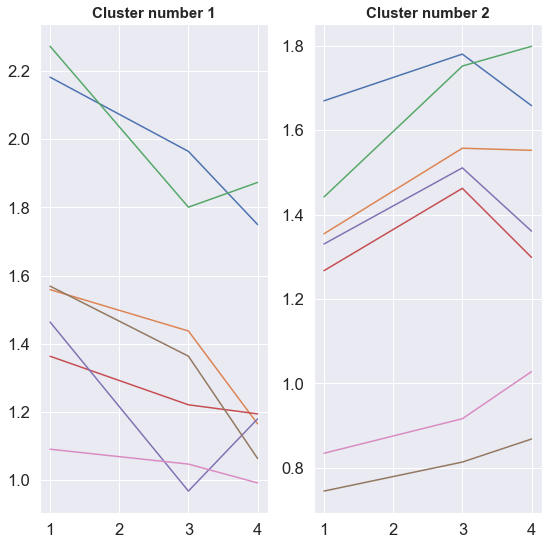

In [65]:
clustered_qPCR = trp.cluster_data_return_df(means_qPCR, target='telo means qPCR', cut_off_n=2,
                                            y_size=9, x_size=9)

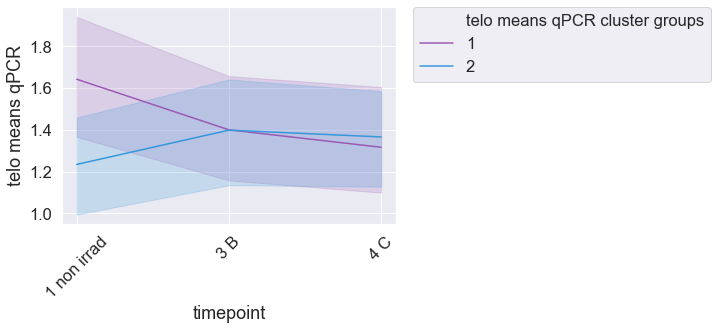

In [66]:
trp.graph_cluster_groups(clustered_qPCR, target='telo means qPCR', hue='telo means qPCR cluster groups')

# Clustering chromosome rearrangement data

In [34]:
all_chr_aberr_df = pd.read_csv('../data/compiled patient data csv files/all_chr_aberr_df.csv')

general_cleaner = Pipeline([('cleaner', trp.general_chr_aberr_cleaner(drop_what_timepoint=False))])
cleaned_chr_df = general_cleaner.fit_transform(all_chr_aberr_df)
mean_chr = cleaned_chr_df.groupby(['patient id', 'timepoint']).agg('mean').reset_index()

## Testing cluster functions on inversions

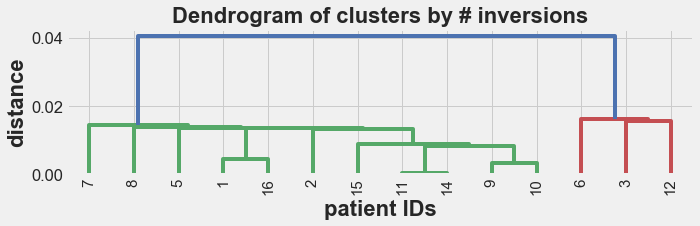

0 Cluster number 1 has 11 elements
1 Cluster number 2 has 3 elements


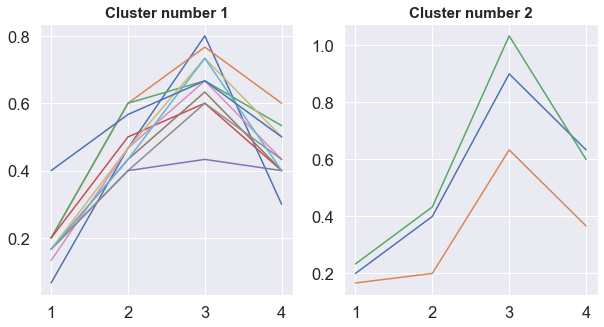

In [68]:
clustered_invs = trp.cluster_data_return_df(mean_chr, target='# inversions', cut_off_n=2,
                                            y_size=5, x_size=10)

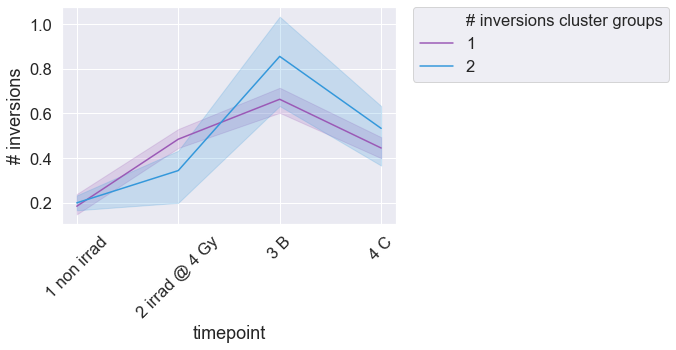

In [69]:
trp.graph_cluster_groups(clustered_invs, target='# inversions', hue='# inversions cluster groups')

# inversions CLUSTER 1 | patient IDs: [1, 2, 5, 7, 8, 9, 10, 11, 14, 15, 16]
# inversions CLUSTER 2 | patient IDs: [3, 6, 12]


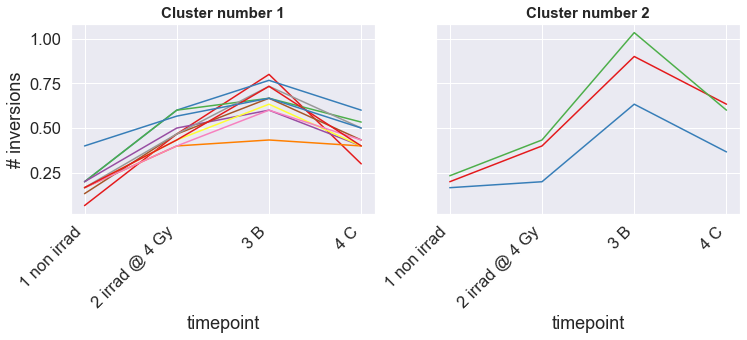

In [70]:
trp.graph_clusters_per_patient(clustered_invs, target='# inversions', y_dimen=1, x_dimen=2, fsize=(12,3.5))

## Looping through all clustered groups graphs

In [71]:
# chr_aberr = ['# inversions', '# terminal inversions', '# translocations', '# dicentrics']

# for target in chr_aberr:
#     if target == '# inversions':
#         n = 2
#     else:
#         n = 1
#     clustered = trp.cluster_data_return_df(mean_chr, target=target, cut_off_n=n)
#     trp.graph_cluster_groups(clustered, target=target, hue=f'{target} cluster groups')
#     trp.graph_clusters_per_patient(clustered, target=target, y_dimen=1, x_dimen=2, fsize=(12,3.5))

## Graphing all aberration cluster groups at once

In [35]:
mean_chr['aberration index'] = (mean_chr['# inversions'] + mean_chr['# terminal inversions'] +
                                mean_chr['# translocations'] + mean_chr['# dicentrics'])

In [36]:
# initializing list of aberrations to cluster by
y_list = ['# inversions', 
          '# terminal inversions', 
          '# translocations', 
          '# dicentrics', 
          'aberration index']

# initializing list of dfs bearing clustered groups
inv_df = trp.cluster_data_return_df(mean_chr, target='# inversions', cut_off_n=2, verbose=False)
term_inv_df = trp.cluster_data_return_df(mean_chr, target='# terminal inversions', cut_off_n=1, verbose=False)
trans_df = trp.cluster_data_return_df(mean_chr, target='# translocations', cut_off_n=1, verbose=False)
dicent_df = trp.cluster_data_return_df(mean_chr, target='# dicentrics', cut_off_n=1, verbose=False)
aberr_index_df = trp.cluster_data_return_df(mean_chr, target='aberration index', cut_off_n=1, verbose=False)

df_list = [inv_df, 
           term_inv_df,
           trans_df, 
           dicent_df,
           aberr_index_df]

# hues to graph by
hue_list = ['# inversions cluster groups', 
            '# terminal inversions cluster groups', 
            '# translocations cluster groups', 
            '# dicentrics cluster groups', 
            'aberration index cluster groups']

# dimensions for each aberration
ylim_dict = {'# inversions': (.1, 1.4),
             '# terminal inversions': (.1, .4),
             '# translocations': (0, .35),
             '# dicentrics': (0, 1),
             'aberration index': (.2, 2.2)}

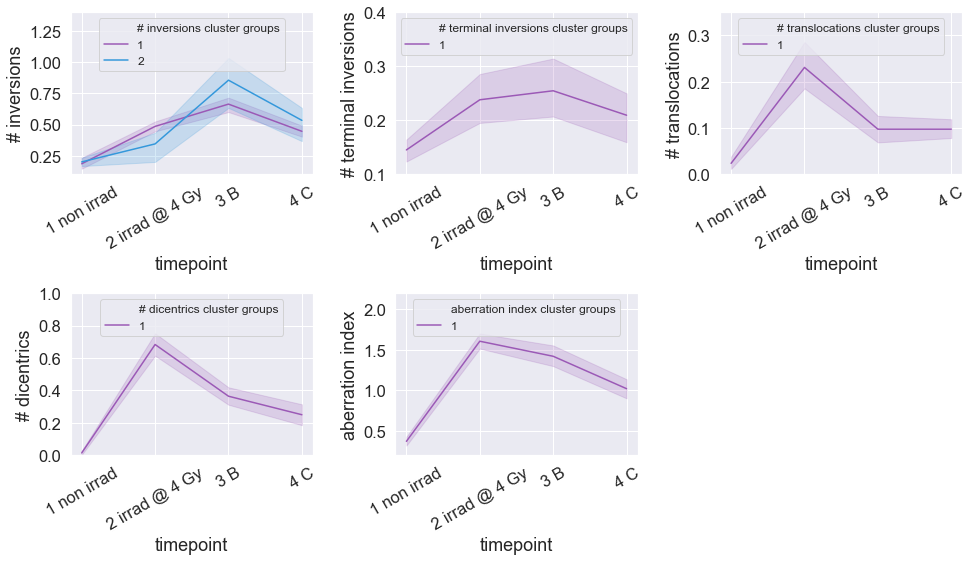

In [37]:
trp.plot_multiple_types_clusters(y_list=y_list, hue_list=hue_list,
                                 df_list=df_list, ylim_dict=ylim_dict)